In [9]:
import numpy as np
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import itertools
from copy import deepcopy as dcopy,copy
from skimage.morphology import label
from scipy.ndimage import measurements
import sys
import time


In [11]:
# Working through the hooks puzzles.
# Back to my solution for hooks 3 with forced cells and then backtracking. 
# Determine the valid hook placements
# then loop through the rows and columns to determine forced cells 
# if these are mismatched on the row and column loop flag as inconsistent
# then solve the final grid with backtracking

url='https://www.janestreet.com/puzzles/block-party-3/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
x =[text for text in soup.body.stripped_strings]

print(" ".join(x[7:21]))

Fill each region with the digits 1 though N , where N is the number of cells in the given region. For every cell in the grid, if K denotes the number in that cell, then the nearest value of K (looking only horizontally or vertically) must be located exactly K cells away. (As in the example, below.) Some of the cells have already been filled in. Once the grid is completed, take the largest “horizontally concatenated number” from each region and compute the sum of these values. Enter this sum as your answer. Good luck!


### Puzzle details
<img src="https://www.janestreet.com/puzzles/wp-content/uploads/2019/09/20190903_block_party_3.png" width="500" height="300">

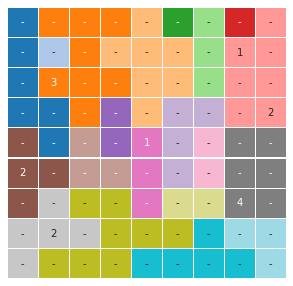

In [12]:
groups=np.array([[0 ,2 ,2 ,2 ,3 ,4 ,5 ,6 ,7 ],
                 [0 ,1 ,2 ,3 ,3 ,3 ,5 ,7 ,7 ],
                 [0 ,2 ,2 ,2 ,3 ,3 ,5 ,7 ,7 ],
                 [0 ,0 ,2 ,8 ,3 ,9 ,9 ,7 ,7 ],
                 [10,0 ,11,8 ,12,9 ,13,14,14],
                 [10,10,11,11,12,9 ,13,14,14],
                 [10,15,16,16,12,17,17,14,14],
                 [15,15,15,16,16,16,18,19,19],
                 [15,16,16,16,18,18,18,18,19]
                 ],dtype=int)

fixed =np.array([[0,0,0,0,0,0,0,0,0],
                 [0,0,0,0,0,0,0,1,0],
                 [0,3,0,0,0,0,0,0,0],
                 [0,0,0,0,0,0,0,0,2],
                 [0,0,0,0,1,0,0,0,0],
                 [2,0,0,0,0,0,0,0,0],
                 [0,0,0,0,0,0,0,4,0],
                 [0,2,0,0,0,0,0,0,0],
                 [0,0,0,0,0,0,0,0,0]
                 ],dtype=int)

def grid_print(groups,numbers):
    fig,ax = plt.subplots(1,1,figsize=(5,5))
    x = np.array((numbers).astype('int').astype('str'))
    x[x=="0"] ="-"
    ax = sns.heatmap(groups,annot=x,cbar=False,cmap="tab20",fmt="",linewidths=0.25)
    ax.axis("off")
    
grid_print(groups,fixed) 


### Puzzle details
<img src="https://www.janestreet.com/puzzles/wp-content/uploads/2019/09/20190903_block_party_3.png" width="400" height="300">

In [13]:
class Matrix():
    def __init__(self,groups,fixed):
        self.groups = groups
        self.fixed = fixed
        self.solution = []
        self.group_dict ={}
        for n in range(20):
            self.group_dict[n] = list(np.arange(1,np.sum(self.groups==n)+1))
    
    def forced(self):
        changed =1
        while changed  ==1:
            changed =0
            for i,j in itertools.product(range(9),range(9)):
                group = self.groups[i,j]
                if self.fixed[i,j] == 0: 
                    if len(self.group_dict[group]) ==1:
                        num = self.group_dict[group].pop(0)
                        self.fixed[i,j] = num
                        changed = 1
                else:
                    num = self.fixed[i,j]
                    if num in self.group_dict[group]:
                        self.group_dict[group].remove(num)
                        changed=1     
            
                        
    def solve(self):
        for row,col in itertools.product(range(9),range(9)):
            
             if self.fixed[row,col]==0:
                group = self.groups[row,col]
                loop = dcopy(self.group_dict[group])
                for n in loop:
                    if self.possible(n,row,col):
                        self.fixed[row,col] = n
                        self.group_dict[group].remove(n)
                        self.solve()
                        self.fixed[row,col] = 0
                        self.group_dict[group].append(n)
                return
        if self.final_test():    
            self.solution.append(dcopy(self.fixed))

    def possible(self,n,row,col):
        for i in range(1,n):
             if np.any(self.n_neighbour(i,row,col)==n):
                    return False
        neighbours = self.n_neighbour(n,row,col)
        
        if 0 not in neighbours:
            if n not in neighbours:
                return False 
        test =dcopy(self.fixed)
        for i,j in itertools.product(range(9),range(9)):
            num = self.fixed[i,j]
            if num ==n :
                neighbours = self.n_neighbour(num,i,j)
                if 0 not in neighbours:
                    if num not in neighbours:
                        return False
          
        return True
   
    def final_test(self):
        for i,j in itertools.product(range(9),range(9)):
            num = self.fixed[i,j]
            neighbours = self.n_neighbour(num,i,j)
            if num not in neighbours:
                return False
        return True

    def n_neighbour(self,n,row,col):
        neighbours = []
        if row-n >-1:
            neighbours.append(self.fixed[row-n,col])
        if col-n >-1:
            neighbours.append(self.fixed[row,col-n])
        if row+n <9:
            neighbours.append(self.fixed[row+n,col])
        if col+n <9:
            neighbours.append(self.fixed[row,col+n])
        return neighbours

def counter(groups,solved):
    group_poss = []
    for i in range(20):
        group_poss.append([0])
    
    group = 0
    total =0
    for i,j in itertools.product(range(9),range(9)):  
        num = solved[i,j]
        if groups[i,j] == group:
            total *=10
            total += num
        else:
            group_poss[group].append(total)
            group = groups[i,j]
            total = num
     
    prod = 0
    for i in range(20):
        prod +=max(group_poss[i])
        
    return prod

In [22]:
solution=np.array([[4,7,8,1,1,1,3,1,7],
                   [1,1,2,7,2,6,1,1,3],
                   [5,3,6,4,3,5,2,4,6],
                   [3,2,5,2,4,2,3,5,2],
                   [4,6,3,1,1,4,2,6,3],
                   [2,1,2,1,3,1,1,1,2],
                   [3,1,1,5,2,1,2,4,5],
                   [5,2,3,2,4,6,1,1,3],
                   [4,3,8,7,3,4,2,5,2]
                 ])

fixed =np.array([[0,7,8,0,0,0,0,0,7],
                 [0,0,0,7,0,0,0,1,0],
                 [0,3,0,0,0,0,0,0,0],
                 [0,0,0,0,0,0,0,0,2],
                 [0,0,0,0,1,0,0,0,0],
                 [2,0,0,0,0,0,0,0,0],
                 [0,0,0,0,0,0,0,4,0],
                 [0,2,0,2,0,0,0,0,0],
                 [0,0,8,7,0,0,0,0,0]
                 ])



In [ ]:
start = time.perf_counter()
matrix = Matrix(groups,fixed)          
#display(matrix.group_dict)
matrix.forced()
#display(matrix.group_dict)
matrix.solve()
stop =  time.perf_counter()
print('\nSolution took {:0.6f} seconds\n'.format((stop-start)))
grid_print(matrix.groups,matrix.solution[0])
#print(len(matrix.solution))
print("number incorrect :",np.sum(matrix.solution[0]!=solved))

In [ ]:
print("The sum of largest concatenated numbers is : {:,.0f}".format(counter(matrix.groups,matrix.solution[0]))

In [ ]:
url='https://www.janestreet.com/puzzles/solutions/september-2019-solution/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
x =[text for text in soup.body.stripped_strings]

print(" ".join(x[7:9]))

### Puzzle solution
<img src="https://www.janestreet.com/puzzles/wp-content/uploads/2019/10/20190931_block_party_3_sol.png" width="300" height="400">

In [ ]:
solved=np.array([[4,7,8,1,1,1,3,1,7],
                   [1,1,2,7,2,6,1,1,3],
                   [5,3,6,4,3,5,2,4,6],
                   [3,2,5,2,4,2,3,5,2],
                   [4,6,3,1,1,4,2,6,3],
                   [2,1,2,1,3,1,1,1,2],
                   [3,1,1,5,2,1,2,4,5],
                   [5,2,3,2,4,6,1,1,3],
                   [4,3,8,7,3,4,2,5,2]
                 ])